## Setting the path for test images

In [1]:
graphene_path = './data_demo/Flakesearch_Graphene_20180214175340935_087.png'
RCE_path = './data_demo/RCEvase/RCEvase_1zn_MapON_ScanON_AeON_FuE_2_Delta_0001.png'
RCE_psi_path = './data_demo/RCEvase/RCEvase_1zn_MapON_ScanON_AeON_FuE_2_Psi_0001.png'

## Import libraries and modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.segmentation import (morphological_chan_vese,
                                  morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  checkerboard_level_set)
from nanofilm.ndimage import imread
import numpy.ma as ma

from skimage.feature import canny



### Read map image and clean NaNs

In [3]:
def map_load_cleannans(image, fill_value=0, copy=False):
    #input diferent fill_value, like np.mean(image) or np.median(image)
    #overrides the values in input image. Returned image is only a masked array
    image = imread(image).T
    
    image = ma.fix_invalid(image,
                           copy=copy, 
                           fill_value=fill_value)
    return image

In [4]:
grapheneRaw = imread(graphene_path).T
grapheneZeros = map_load_cleannans(graphene_path)
grapheneMedian = map_load_cleannans(graphene_path, 
                                    fill_value=np.nanmedian(grapheneRaw))

###### We keep one image where NaNs are replaced by the median of the array in order to use it for some calculations, like the min and max, later on. Otherwise some calculations will not work if the NaNs are there or will be strongly biased by the zeros.

In [5]:
RCEtestRaw = imread(RCE_path).T
RCEtestZeros = map_load_cleannans(RCE_path)
RCEtestMedian = map_load_cleannans(RCE_path, 
                                    fill_value=np.nanmedian(RCEtestRaw))

In [6]:
RCEPsiRaw = imread(RCE_psi_path).T
RCEPsiZeros = map_load_cleannans(RCE_psi_path)
RCEPsiMedian = map_load_cleannans(RCE_psi_path, 
                                    fill_value=np.nanmedian(RCEPsiRaw))

### Retrieving min and max values of the image to set the display contrast

In [7]:
maxcontrast = np.max(grapheneMedian)
mincontrast = np.min(grapheneMedian)

All of the above can be packed in a single function which will return multiple items: all types of image variations plus the required variables, like maxcontras and mincontrast. Or maybe this can be built in a class...

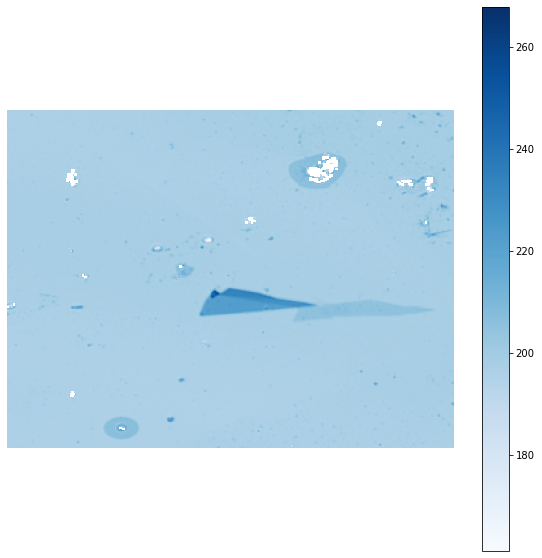

In [8]:
fig, ax = plt.subplots(1, figsize=(10,10) )
ax.set_axis_off()
arrContrast = ax.imshow(grapheneZeros, 
                        vmin = mincontrast,
                        vmax = maxcontrast,
                        cmap = 'Blues')
cbar = plt.colorbar(arrContrast)
#cbar.ax.set_ylabel('$\Delta$ / °')

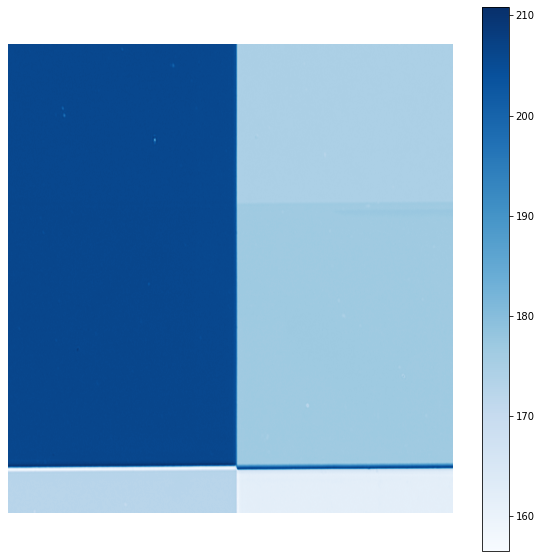

In [9]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax.set_axis_off()
arrContrast = ax.imshow(RCEtestZeros, 
                        vmin = np.min(RCEtestMedian),
                        vmax = np.max(RCEtestMedian),
                        cmap = 'Blues')
cbar = plt.colorbar(arrContrast)
#cbar.ax.set_ylabel('$\Delta$ / °')

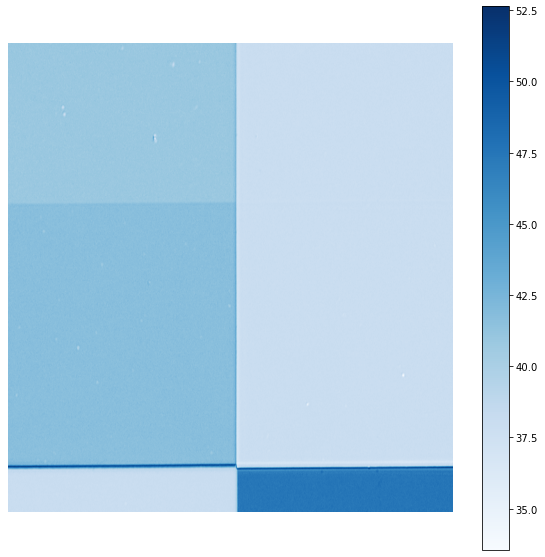

In [10]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax.set_axis_off()
arrContrast = ax.imshow(RCEPsiZeros, 
                        vmin = np.min(RCEPsiMedian),
                        vmax = np.max(RCEPsiMedian),
                        cmap = 'Blues')
cbar = plt.colorbar(arrContrast)
#cbar.ax.set_ylabel('$\Delta$ / °')

# Testing Canny edge detector in unprocessed maps

In [11]:
from skimage.feature import canny

In [12]:
edgedGraphene = canny(grapheneZeros)
edgedDelta = canny(RCEtestZeros)
edgedPsi = canny(RCEPsiZeros)

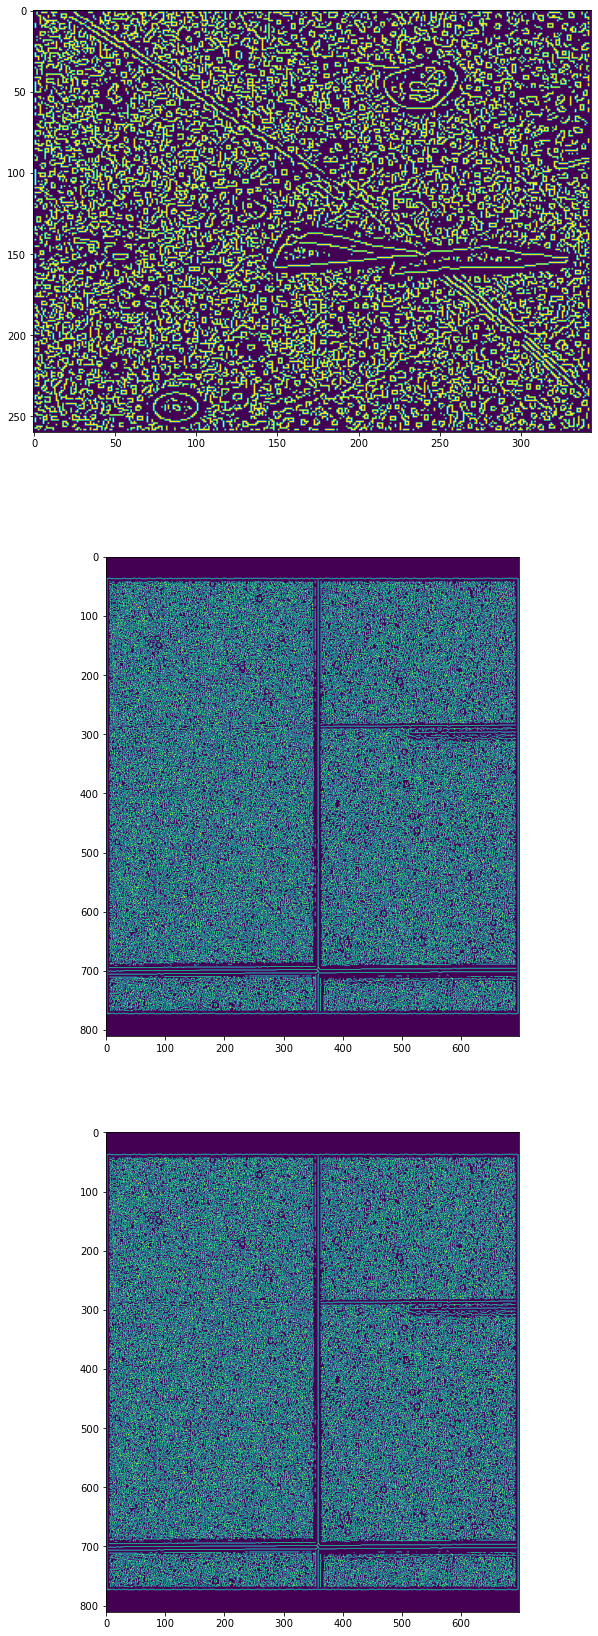

In [13]:
fig, (ax1,ax2,ax3) = plt.subplots(3, figsize=(10,30))
ax1.imshow(edgedGraphene)
ax2.imshow(edgedDelta)
ax3.imshow(edgedDelta)

# Testing Canny edge detector in blurred maps

In [14]:
from skimage.filters import gaussian

In [16]:
blurredGraphene = gaussian(grapheneZeros, preserve_range=True)
blurredDelta = gaussian(RCEtestZeros, preserve_range=True)
blurredPsi = gaussian(RCEPsiZeros, preserve_range=True)

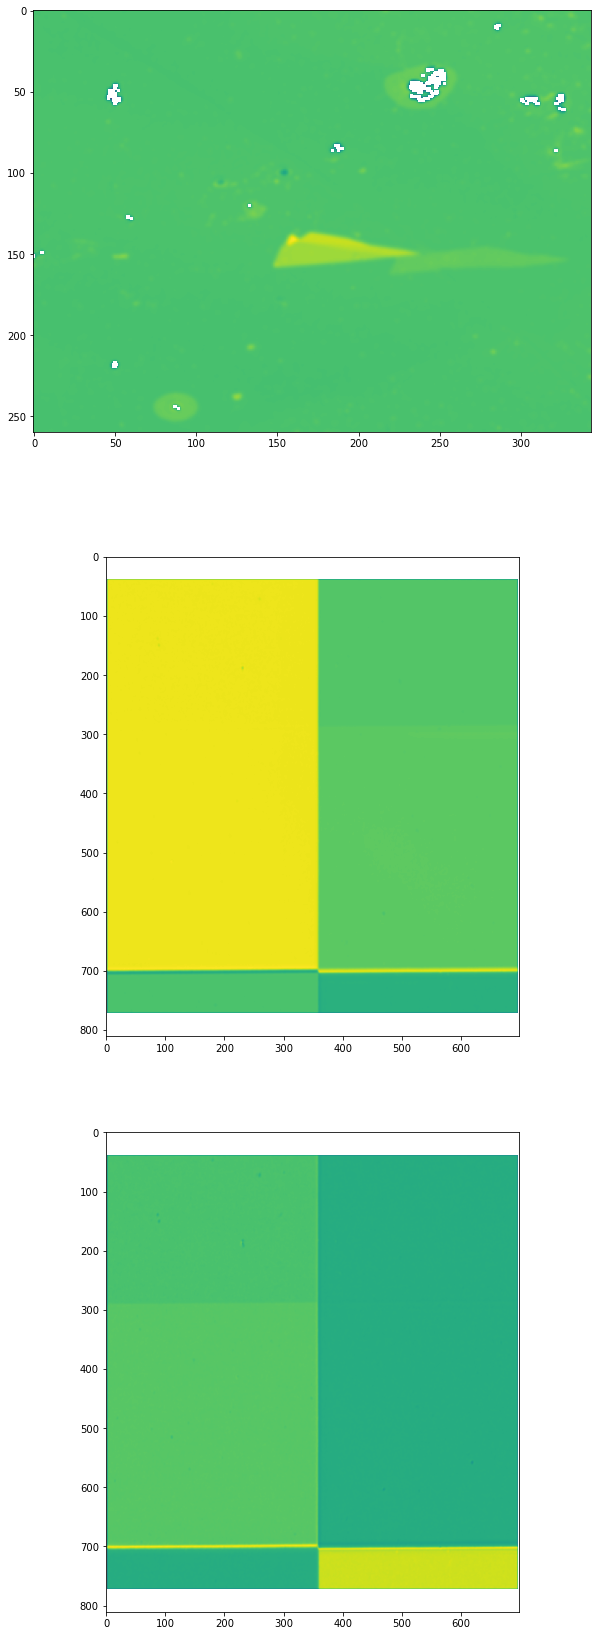

In [17]:
fig, (ax1,ax2,ax3) = plt.subplots(3, figsize=(10,30))
ax1.imshow(blurredGraphene)
ax2.imshow(blurredDelta)
ax3.imshow(blurredPsi)

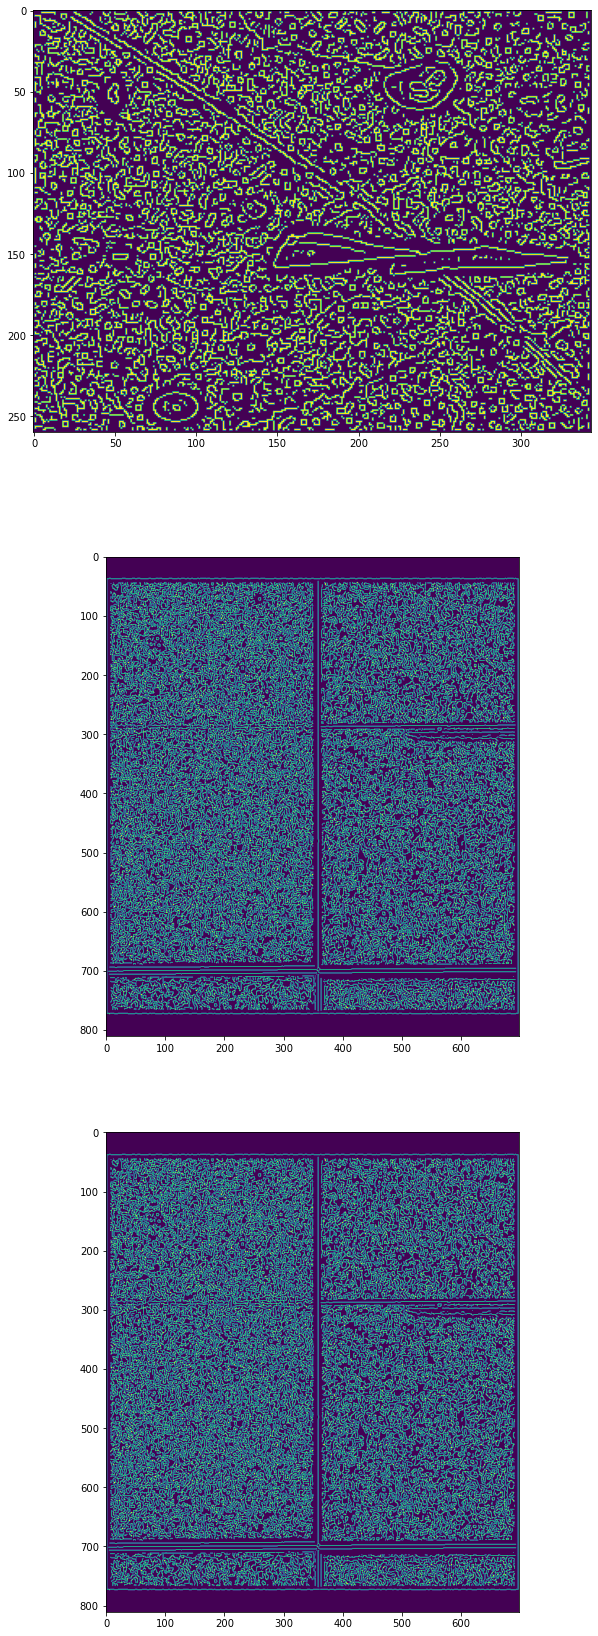

In [18]:
edgedGrapheneBl = canny(blurredGraphene)
edgedDeltaBl = canny(blurredDelta)
edgedPsiBl = canny(blurredPsi)

fig, (ax1,ax2,ax3) = plt.subplots(3, figsize=(10,30))
ax1.imshow(edgedGrapheneBl)
ax2.imshow(edgedDeltaBl)
ax3.imshow(edgedDeltaBl)

#### Playing around with sigma tuning for canny function

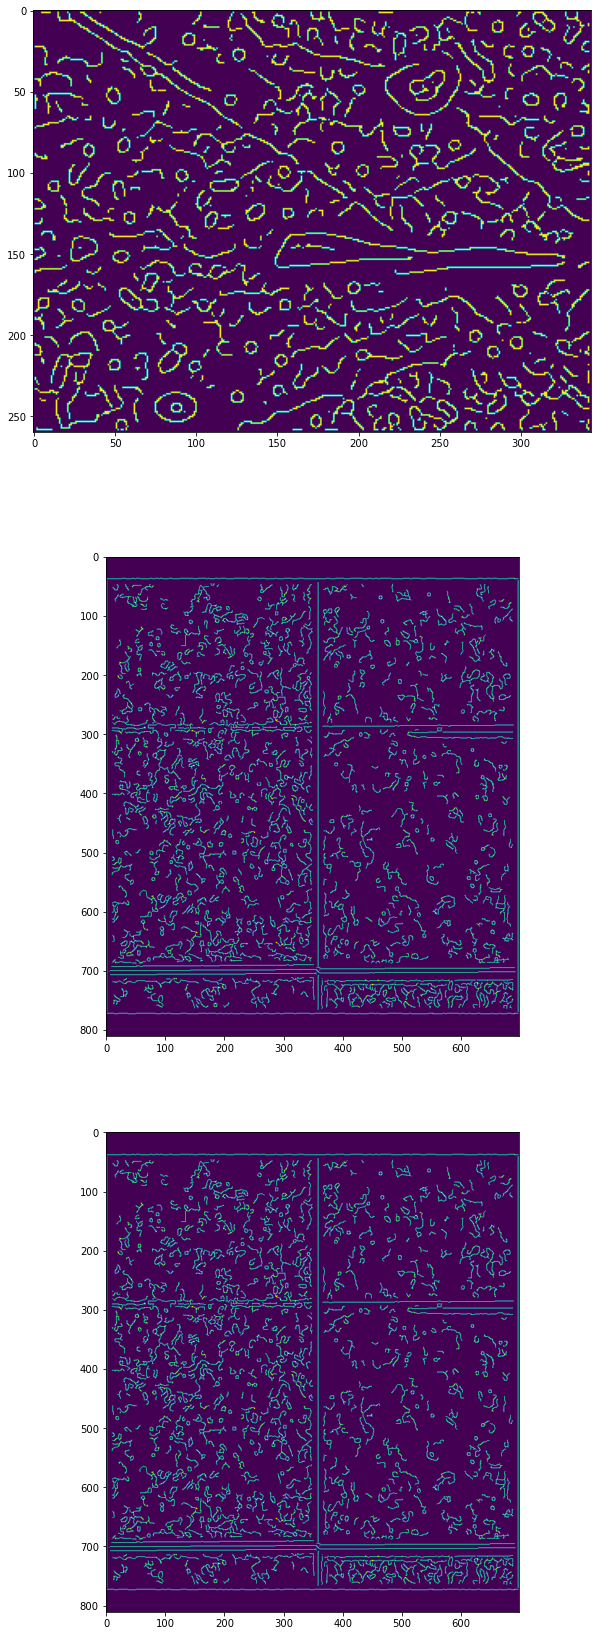

In [24]:
edgedGrapheneBl = canny(blurredGraphene, sigma=3)
edgedDeltaBl = canny(blurredDelta, sigma=2)
edgedPsiBl = canny(blurredPsi, sigma=2.5)

fig, (ax1,ax2,ax3) = plt.subplots(3, figsize=(10,30))
ax1.imshow(edgedGrapheneBl)
ax2.imshow(edgedDeltaBl)
ax3.imshow(edgedDeltaBl)

Canny does not look suitable for the automatic edge detection in our image maps. The tunning of sigma parameter in the blurring (which will lead to edge supression if set too high) and the canny itself is hard and non-intuitive. Even high values of sigma in canny will not get rid of the undesired edges due to noise, but will start deleting the true edges. 
The next step is to try other gradient-based edge detection algorithms, like Sobel, Scharr and Prewitt. If this does not work, we will try other methods like adaptative thresholding or active connected components in conbination with active contours methods for feature extraction.

# Trying other gradient based filters

In [25]:
from skimage import filters

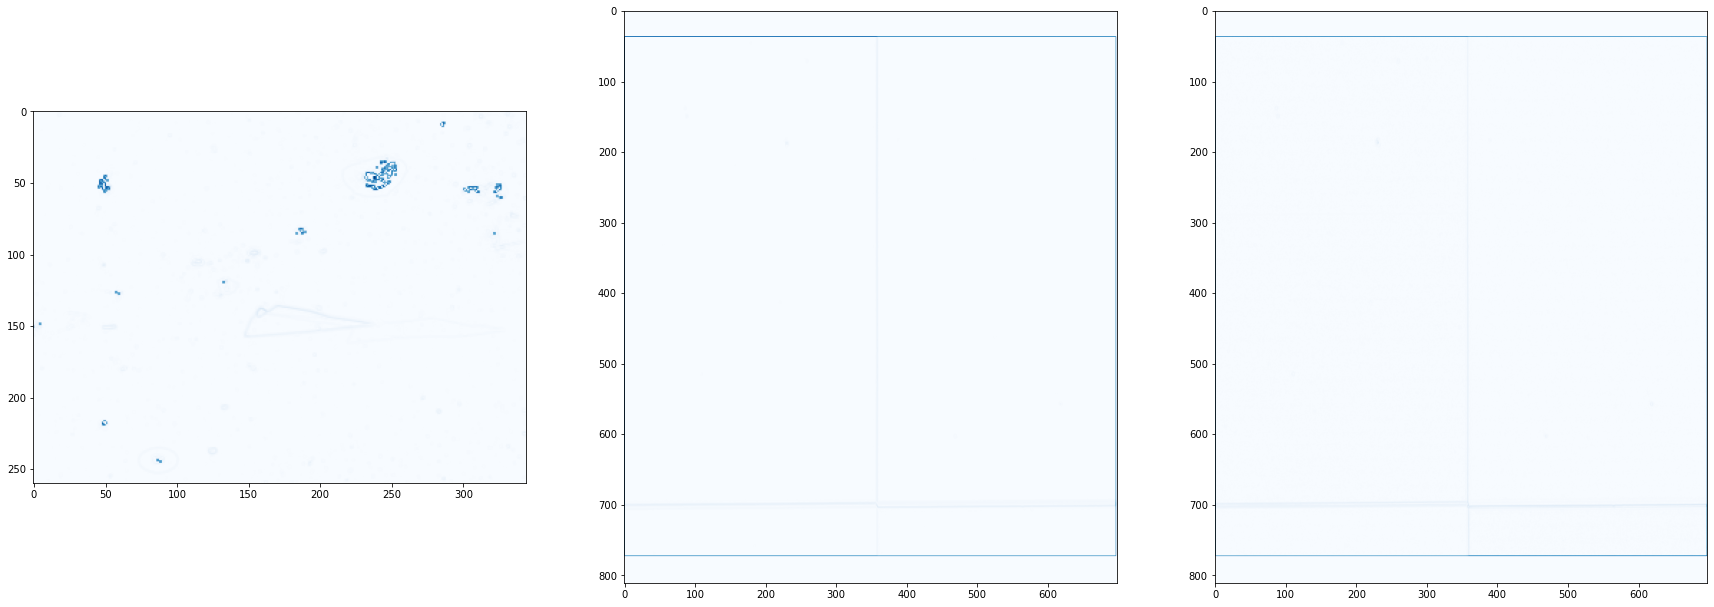

In [34]:
edge_roberts_graphene = filters.roberts(grapheneZeros)
edge_roberts_delta = filters.roberts(RCEtestZeros)
edge_roberts_psi = filters.roberts(RCEPsiZeros)

fig, axes = plt.subplots(ncols=3, figsize=(30,15))
axes[0].imshow(edge_roberts_graphene, cmap='Blues')
axes[1].imshow(edge_roberts_delta, cmap='Blues')
axes[2].imshow(edge_roberts_psi, cmap='Blues')

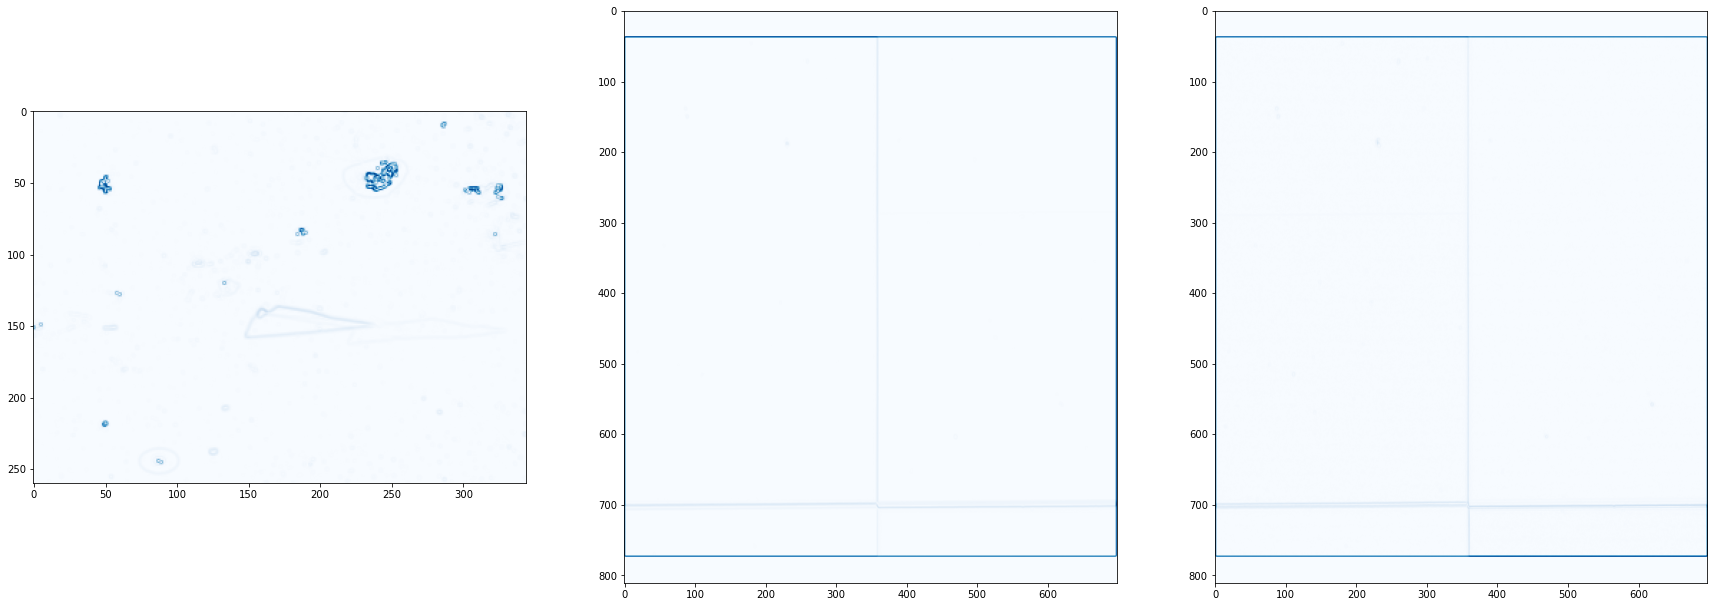

In [37]:
edge_sobel_graphene = filters.sobel(grapheneZeros)
edge_sobel_delta = filters.sobel(RCEtestZeros)
edge_sobel_psi = filters.sobel(RCEPsiZeros)

fig, axes = plt.subplots(ncols=3, figsize=(30,15))
axes[0].imshow(edge_sobel_graphene, cmap='Blues')
axes[1].imshow(edge_sobel_delta, cmap='Blues')
axes[2].imshow(edge_sobel_psi, cmap='Blues')

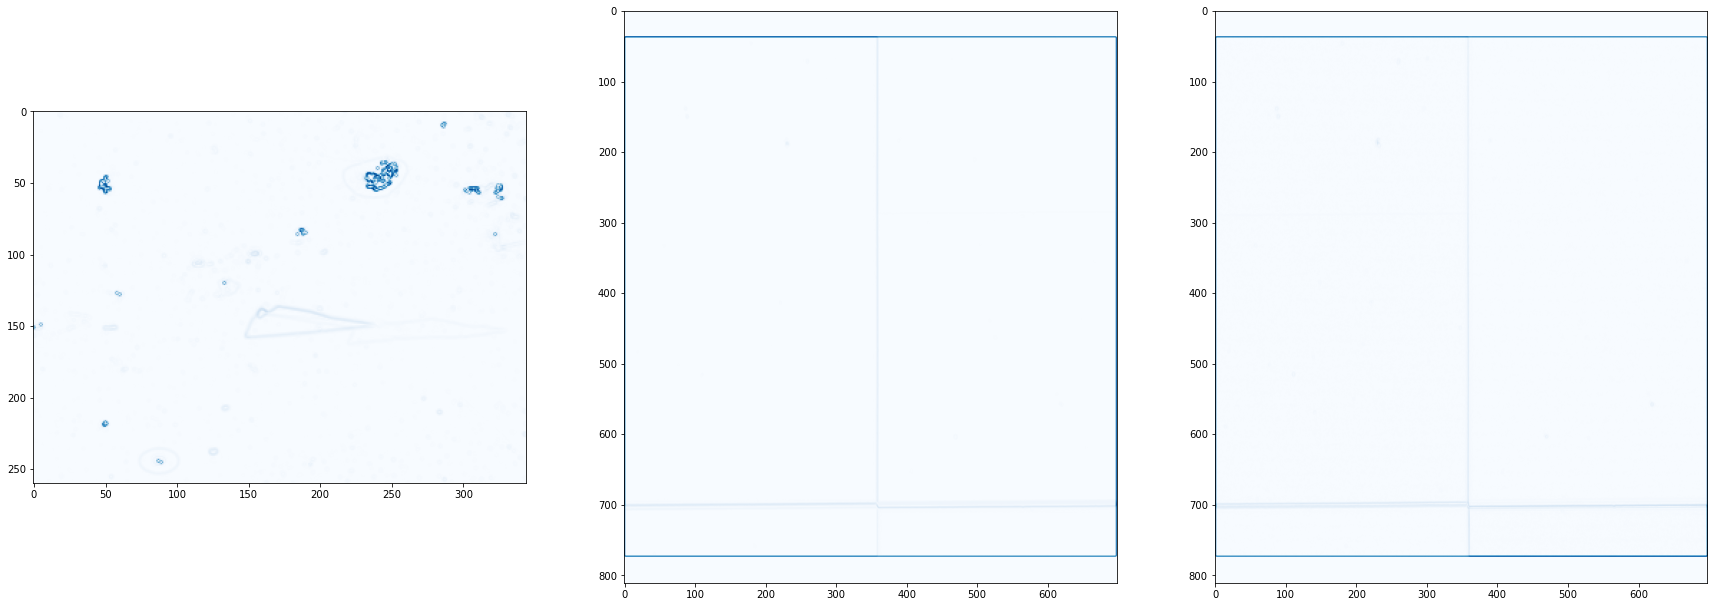

In [38]:
edge_scharr_graphene = filters.scharr(grapheneZeros)
edge_scharr_delta = filters.scharr(RCEtestZeros)
edge_scharr_psi = filters.scharr(RCEPsiZeros)

fig, axes = plt.subplots(ncols=3, figsize=(30,15))
axes[0].imshow(edge_scharr_graphene, cmap='Blues')
axes[1].imshow(edge_scharr_delta, cmap='Blues')
axes[2].imshow(edge_scharr_psi, cmap='Blues')

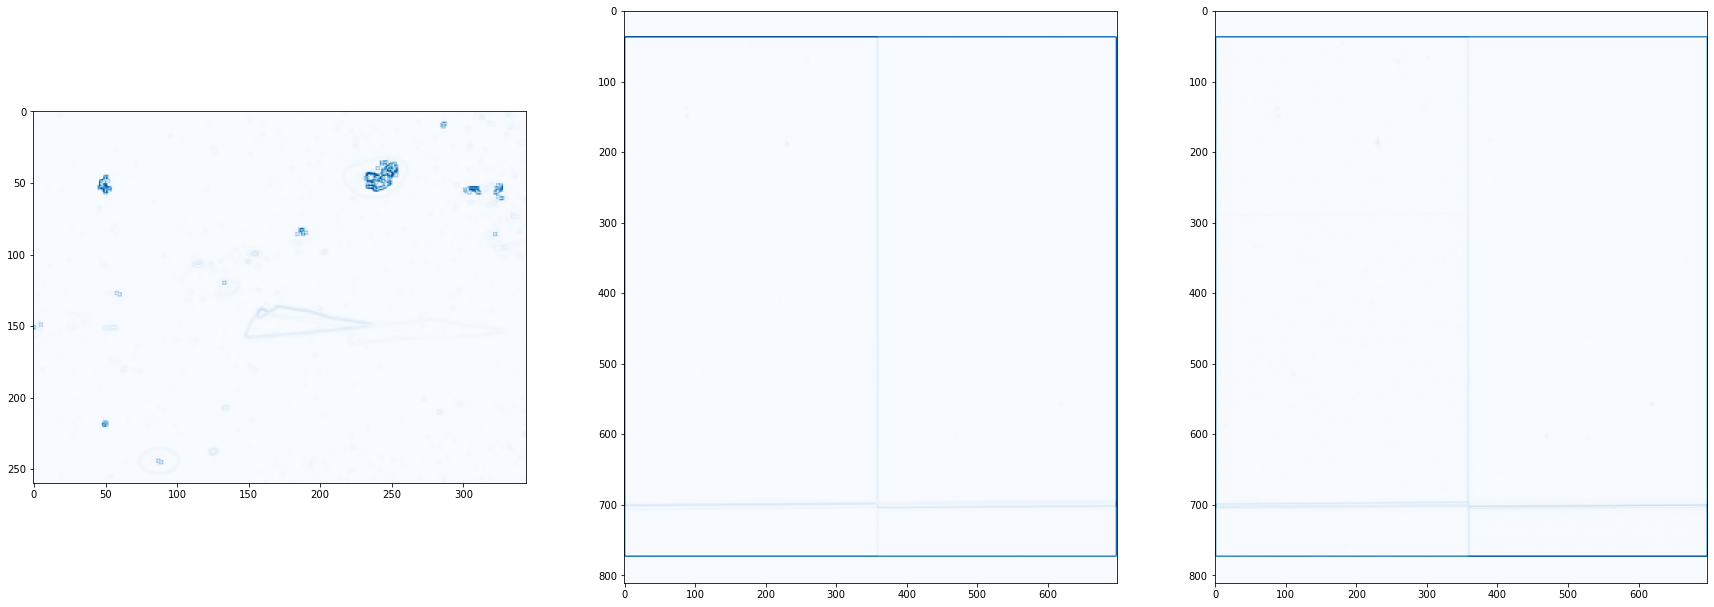

In [39]:
edge_prewitt_graphene = filters.prewitt(grapheneZeros)
edge_prewitt_delta = filters.prewitt(RCEtestZeros)
edge_prewitt_psi = filters.prewitt(RCEPsiZeros)

fig, axes = plt.subplots(ncols=3, figsize=(30,15))
axes[0].imshow(edge_prewitt_graphene, cmap='Blues')
axes[1].imshow(edge_prewitt_delta, cmap='Blues')
axes[2].imshow(edge_prewitt_psi, cmap='Blues')

The differences between methods are small, but the Roberts seems the weakest. They all fail to detect the soft edges inside the larger areas of the RCE maps. 

#### Comparison of best 3 methods in one figure compared to original

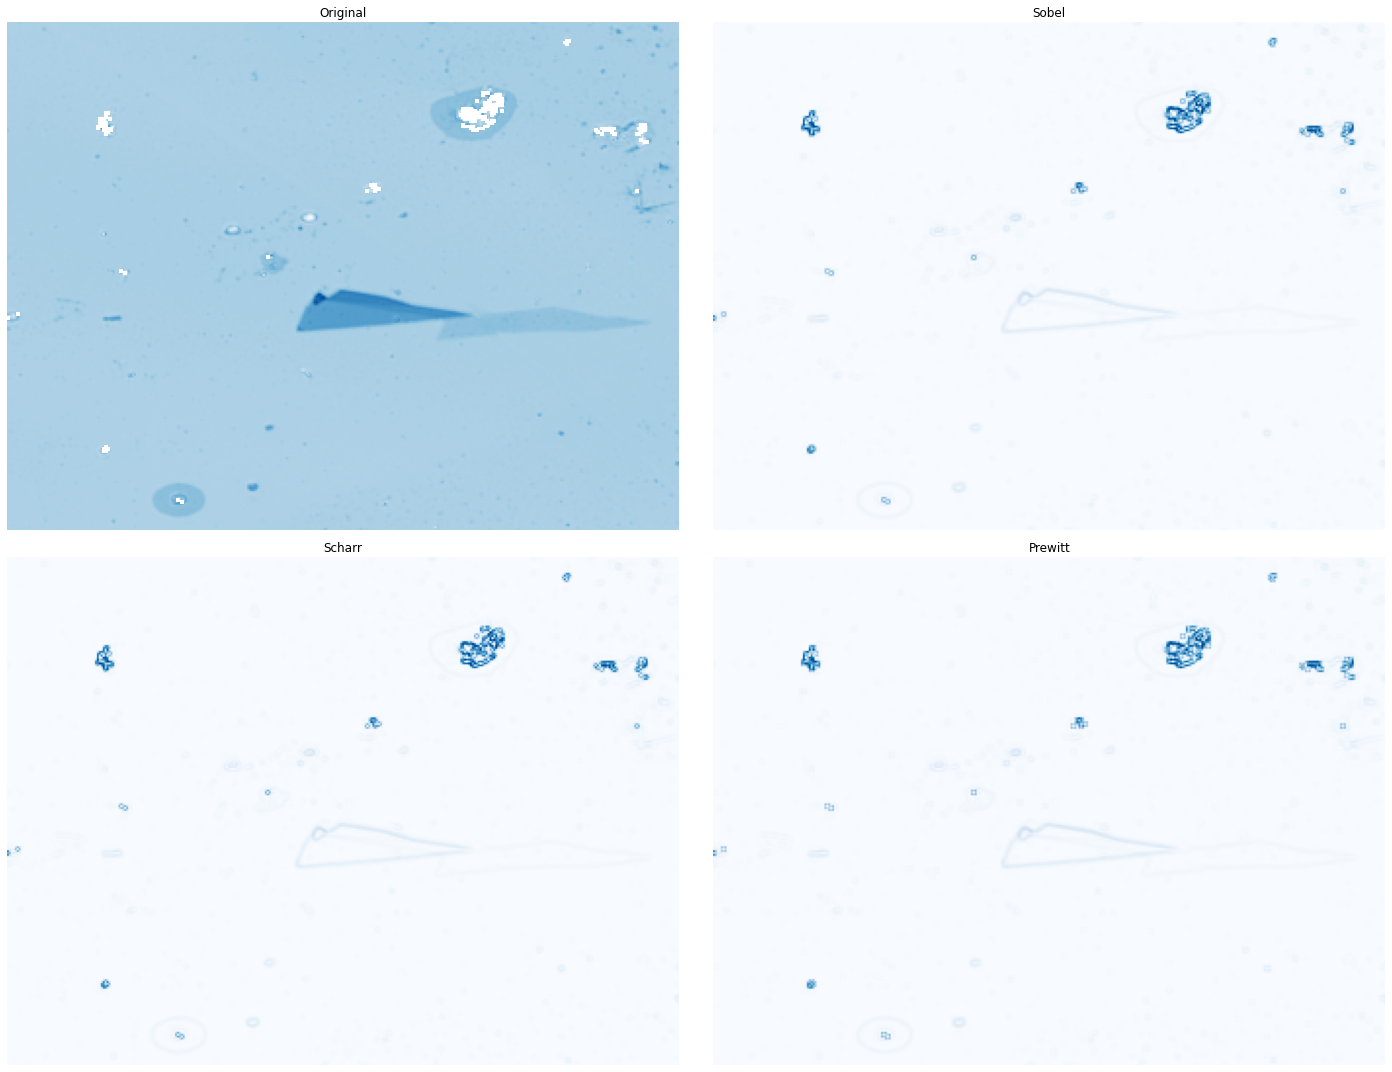

In [59]:
fig, axes = plt.subplots(2,2, figsize=(20,15))

axes[0,0].imshow(grapheneZeros, cmap='Blues')
axes[0,0].set_title('Original')
axes[0,0].axis('off')
axes[0,1].imshow(edge_sobel_graphene, cmap='Blues')
axes[0,1].set_title('Sobel')
axes[0,1].axis('off')
axes[1,0].imshow(edge_scharr_graphene, cmap='Blues')
axes[1,0].set_title('Scharr')
axes[1,0].axis('off')
axes[1,1].imshow(edge_prewitt_graphene, cmap='Blues')
axes[1,1].set_title('Prewitt')
axes[1,1].axis('off')
    
plt.tight_layout()

plt.show()

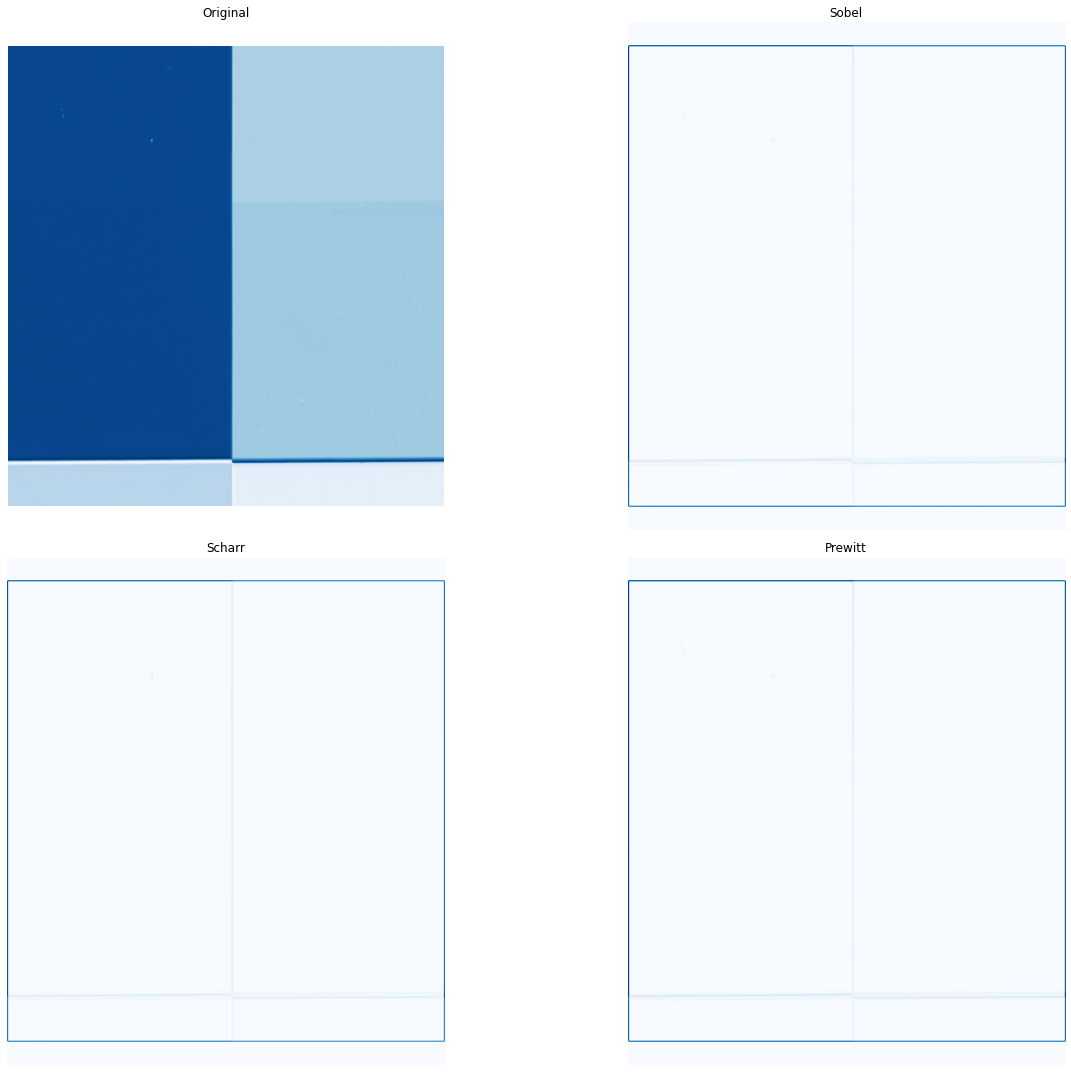

In [62]:
fig, axes = plt.subplots(2,2, figsize=(20,15))

axes[0,0].imshow(RCEtestZeros, cmap='Blues')
axes[0,0].set_title('Original')
axes[0,0].axis('off')
axes[0,1].imshow(edge_sobel_delta, cmap='Blues')
axes[0,1].set_title('Sobel')
axes[0,1].axis('off')
axes[1,0].imshow(edge_scharr_delta, cmap='Blues')
axes[1,0].set_title('Scharr')
axes[1,0].axis('off')
axes[1,1].imshow(edge_prewitt_delta, cmap='Blues')
axes[1,1].set_title('Prewitt')
axes[1,1].axis('off')
    
plt.tight_layout()

plt.show()